In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [8]:
if torch.cuda.is_available():  
    DEVICE = "cuda:0"
    print('Using cuda!')
    print(torch.cuda.current_device())
else:
    DEVICE = "cpu"
DEVICE

Using cuda!
0


'cuda:0'

In [3]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

train_dir = './ImageEmotionDatasetMid/train'
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

train_dataset.classes

['amusement', 'awe', 'contentment', 'excitement', 'sadness']

In [4]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

In [5]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model_conv = model_conv.to(DEVICE)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.001)

In [19]:
epochs = 20

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model_conv(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # stats
        running_loss += loss.item()
    
    # end of epoch
    print(f'Epoch {epoch} - loss: {running_loss}')

print('Finished training')

Epoch 0 - loss: 41.53284075856209
Epoch 1 - loss: 39.475542932748795
Epoch 2 - loss: 39.75053554773331
Epoch 3 - loss: 39.12146544456482
Epoch 4 - loss: 40.65901690721512
Epoch 5 - loss: 37.55841055512428
Epoch 6 - loss: 39.47539272904396
Epoch 7 - loss: 40.16147115826607
Epoch 8 - loss: 36.57956311106682
Epoch 9 - loss: 36.307767033576965
Epoch 10 - loss: 37.81792238354683
Epoch 11 - loss: 38.033308535814285
Epoch 12 - loss: 36.976015865802765
Epoch 13 - loss: 36.27400627732277
Epoch 14 - loss: 36.979660391807556
Epoch 15 - loss: 35.7056659758091
Epoch 16 - loss: 36.75566416978836
Epoch 17 - loss: 38.27132958173752
Epoch 18 - loss: 35.677014738321304
Epoch 19 - loss: 35.84717082977295
Finished training


In [20]:
save_dir = './test_model_resnet.pth'
torch.save(model_conv.fc.state_dict(), save_dir)

In [11]:
test_dir = './ImageEmotionDatasetMid/test'
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

test_dataset.classes

['amusement', 'awe', 'contentment', 'excitement', 'sadness']

In [12]:
# copied this from the sample lol
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [13]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

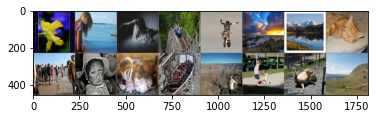

Ground Truth:  contentment sadness sadness amusement


In [21]:
dataiter = iter(test_loader)

images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' % test_dataset.classes[labels[j]] for j in range(4)))

In [22]:
with torch.no_grad():
    outputs = model_conv(images.to(DEVICE))
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % test_dataset.classes[predicted[j]] for j in range(4)))

Predicted:    awe contentment sadness excitement


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on all test images: %d %%' % (100 * correct / total))

Accuracy of the network on all test images: 57 %


In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on all train images: %d %%' % (100 * correct / total))

Accuracy of the network on all train images: 78 %


lmao completely overfitted